In [22]:
import numpy as np
import xarray as xr
import os
import gsw
from matplotlib import pyplot as plt, gridspec, dates
from contextlib import ExitStack
from scipy import signal
from datetime import datetime, timedelta
from dateutil.parser import parse
from tqdm.notebook import tqdm

%matplotlib inline

In [23]:
plt.rcParams['font.size'] = 12

***

### Preliminary code

Functions

In [3]:
def make_prefix(date, res='h', path='/results2/SalishSea/nowcast-green.201905'):
    """Construct path prefix for local SalishSeaCast results given date object and paths dict
    e.g., /results2/SalishSea/nowcast-green.201905/ddmmmyy/SalishSea_1h_yyyymmdd_yyyymmdd
    """

    datestr = '_'.join(np.repeat(date.strftime('%Y%m%d'), 2))
    prefix = os.path.join(path, date.strftime('%d%b%y').lower(), f'SalishSea_1{res}_{datestr}')
    
    return prefix

Run parameters

In [4]:
# NetCDF files
coords = xr.open_dataset('/data/bmoorema/MEOPAR/grid/coordinates_seagrid_SalishSea201702.nc', decode_times=False)
bathy = xr.open_dataset('/data/bmoorema/MEOPAR/grid/bathymetry_201702.nc')
mask = xr.open_dataset('/data/bmoorema/MEOPAR/grid/mesh_mask201702.nc')

# Seasonal cutoffs
cutoffs = {
    2015: [(4, 12), (8, 24)],
    2016: [(4,  7), (8, 22)],
    2017: [(4, 27), (9,  4)],
    2018: [(4,  5), (9,  2)],
    2019: [(4,  2), (9,  6)],
}

# Transects
transects = {
    'QuadraRead'  : {'orient': 'NS', 'kji': (slice(0, 26), slice(763, 767), 151)},
    'ReadCortesS' : {'orient': 'NS', 'kji': (slice(0, 36), slice(751, 761), 160)},
    'QuadraCortes': {'orient': 'EW', 'kji': (slice(0, 34), 735, slice(135, 167))},
    'ReadCortesN' : {'orient': 'EW', 'kji': (slice(0, 39), 768, slice(178, 183))},
    #'NSOG'        : {'orient': 'EW', 'kji': (slice(0, 36), 680, slice(130, 198))},
}

# Wind threshold
threshold = -5

Load HRDPS record at Sentry Shoal

In [5]:
# Load HRDPS at Sentry Shoal
HRDPS = {'time': [], 'data': []}
path = '/ocean/bmoorema/research/MEOPAR/analysis-ben-hg/data/GEM25/'
for year in range(2015, 2020):
    fn = path + f'HRDPS_ops_{year}0101_{year}1231.nc'
    with xr.open_dataset(fn) as ds:

        # Alongaxis wind
        u, v = [ds[var].isel(y=73, x=7).values for var in ['u_wind', 'v_wind']]
        HRDPS['data'].append(np.sin(np.arctan2(v, u) - np.pi * 40 / 180) * np.sqrt(u**2 + v**2))
        HRDPS['time'].append(ds.time_counter.values.astype('datetime64[s]').astype(datetime))

# Concatenate
for key in ['time', 'data']: HRDPS[key] = np.hstack(HRDPS[key])

# Filter
window = signal.get_window('blackman', 73)
HRDPS['filtered'] = signal.convolve(HRDPS['data'], window / sum(window), mode='same')

***

### Analysis

Plot HRDPS record and determine threshold dates

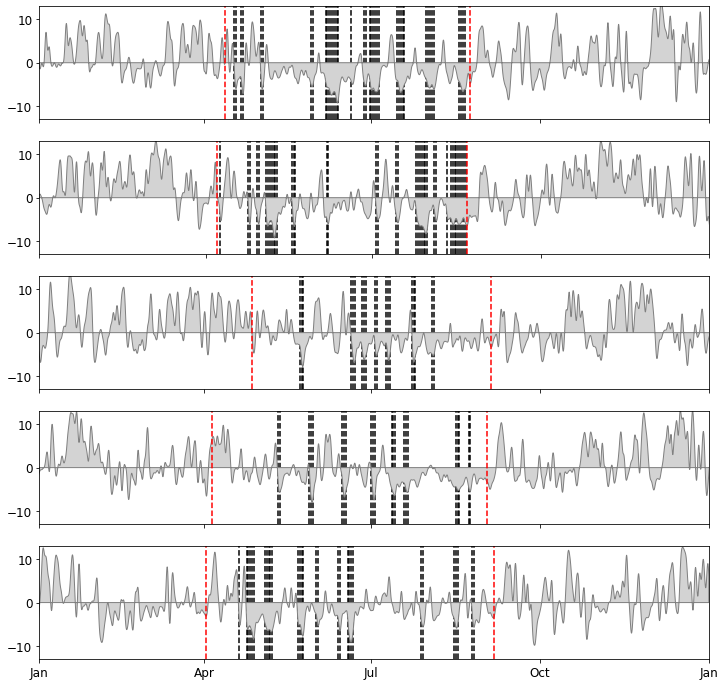

In [6]:
# Make figure layout
fig, axs = plt.subplots(5, 1, figsize=(12, 12))

# Loop through years
upwelling_dates = []
for ax, year in zip(axs, range(2015, 2020)):
    
    # Build seasonal index
    index = True
    for md, func in zip(cutoffs[year], ['greater', 'less']):
        cutoff = datetime(year, *md)
        ax.plot([cutoff, cutoff], [-13, 13], 'r--')
        index = index & getattr(np, func)(HRDPS['time'], cutoff)
    
    # Find wind threshold dates
    index = index & (HRDPS['filtered'] < threshold)
    
    upwelling_dates.append(np.unique([parse(t.strftime('%Y-%b-%d')) for t in HRDPS['time'][index]]))
    
    # Plot wind
    ax.fill_between(HRDPS['time'], HRDPS['filtered'], facecolor='lightgray', edgecolor='gray')
    ax.set_xlim(datetime(year, 1, 1), datetime(year+1, 1, 1))
    ax.set_ylim([-13, 13])
    ax.xaxis.set_major_locator(dates.MonthLocator(interval=3))
    ax.xaxis.set_major_formatter(dates.DateFormatter('%b'))
    if year < 2019: ax.xaxis.set_ticklabels('')

    # Plot dates
    for date in upwelling_dates[-1]:
        ax.plot([date, date], [-13, 13], 'k--', zorder=0)

# Concatenate
upwelling_dates = np.hstack(upwelling_dates)

Plot transects

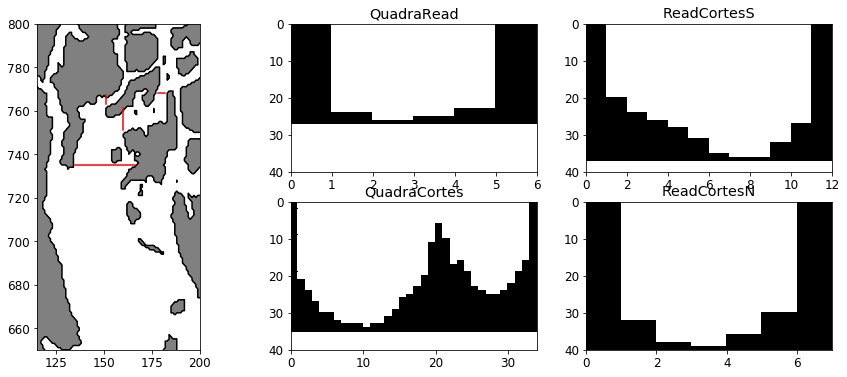

In [7]:
# Make figure
fig = plt.figure(figsize=(15, 6))
gs = gridspec.GridSpec(2, 3)
cols, rows = [dim.flatten() for dim in np.meshgrid(range(1, 3), range(2))]

# Make map
ax_map = fig.add_subplot(gs[:, 0])
ax_map.contourf(mask.vmask[0, 0, ...], levels=[-0.01, 0.01], colors='gray')
ax_map.contour(mask.vmask[0, 0, ...], levels=[-0.01, 0.01], colors='k')
ax_map.set_xlim([115, 200])
ax_map.set_ylim([650, 800])
ax_map.set_aspect(5/4.4)

# Plot transects
for name, row, col in zip(transects, rows, cols):
    ax = fig.add_subplot(gs[row, col])
    orient, kji = [transects[name][key] for key in ['orient', 'kji']]
    if orient == 'NS':
        ax_map.plot([kji[2], kji[2]], [kji[1].start, kji[1].stop], 'r-')
        ax.pcolormesh(mask.umask[0, kji[0].start:kji[0].stop+1, kji[1].start-1:kji[1].stop+1, kji[2]], cmap='Greys_r')
    elif orient == 'EW':
        ax_map.plot([kji[2].start, kji[2].stop-1], [kji[1], kji[1]], 'r-')
        ax.pcolormesh(mask.vmask[0, kji[0].start:kji[0].stop+1, kji[1], kji[2].start-1:kji[2].stop+1], cmap='Greys_r')
    ax.set_ylim([40, 0])
    ax.set_title(name)

***

### Load data

Sandbox

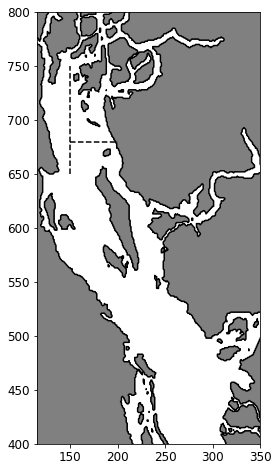

In [45]:
# Make figure
fig, ax = plt.subplots(figsize=(4, 8))

# Make map
ax.contourf(mask.vmask[0, 0, ...], levels=[-0.01, 0.01], colors='gray')
ax.contour(mask.vmask[0, 0, ...], levels=[-0.01, 0.01], colors='k')
ax.set_xlim([115, 350])
ax.set_ylim([400, 800])
ax.set_aspect(5/4.4)

ax.plot([150, 150], [650, 750], 'k--')
ax.plot([150, 200], [680, 680], 'k--')

In [69]:
# Load from file system
T, S, T2, S2 = [], [], [], []
daterange = [datetime(2015, *md) for md in cutoffs[2015]]
for day in tqdm(range(np.diff(daterange)[0].days)):
    with xr.open_dataset(make_prefix(daterange[0] + timedelta(days=day)) + '_grid_T.nc') as ds:
        T.append(ds.votemper.isel(deptht=10, y=slice(650, 750), x=150).values)
        S.append(ds.vosaline.isel(deptht=10, y=slice(650, 750), x=150).values)
        T2.append(ds.votemper.isel(deptht=10, y=680, x=slice(150, 198)).values)
        S2.append(ds.vosaline.isel(deptht=10, y=680, x=slice(150, 198)).values)

In [70]:
S = np.concatenate(S)
T = np.concatenate(T)
rho = gsw.rho(S, T, 10)
S2 = np.concatenate(S2)
T2 = np.concatenate(T2)
rho2 = gsw.rho(S2, T2, 10)
#time = np.array([daterange[0] + timedelta(hours=h) for h in range(rho.shape[0])])

### 10 m

(735700.0, 735834.0)

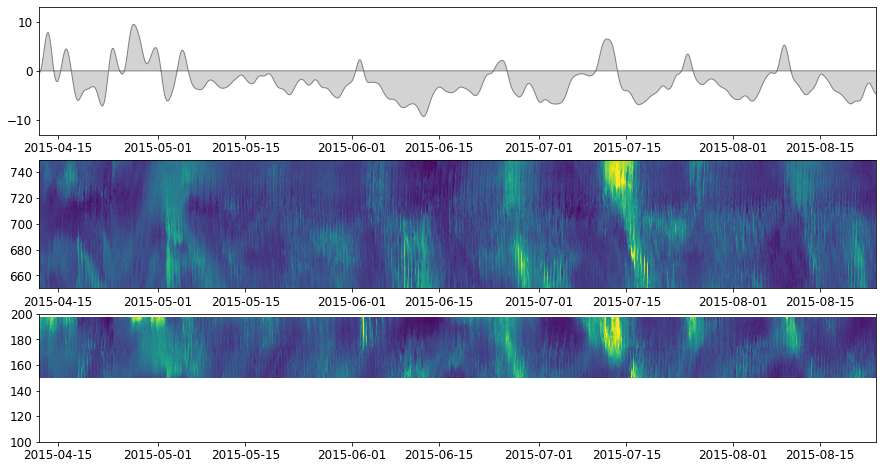

In [76]:
fig, axs = plt.subplots(3, 1, figsize=(15, 8))
axs[0].fill_between(HRDPS['time'], HRDPS['filtered'], facecolor='lightgray', edgecolor='gray')
axs[0].set_ylim([-13, 13])
axs[0].set_xlim(daterange)

axs[1].contourf(time, range(650, 750), rho.T, levels=np.arange(1019, 1023, 0.1), cmap='viridis_r', extend='both')
axs[1].set_xlim(daterange)

axs[2].contourf(time, range(150, 198), rho2.T, levels=np.arange(1019, 1023, 0.1), cmap='viridis_r', extend='both')
axs[2].set_ylim([100, 200])
axs[2].set_xlim(daterange)

### 20 m

(735700.0, 735834.0)

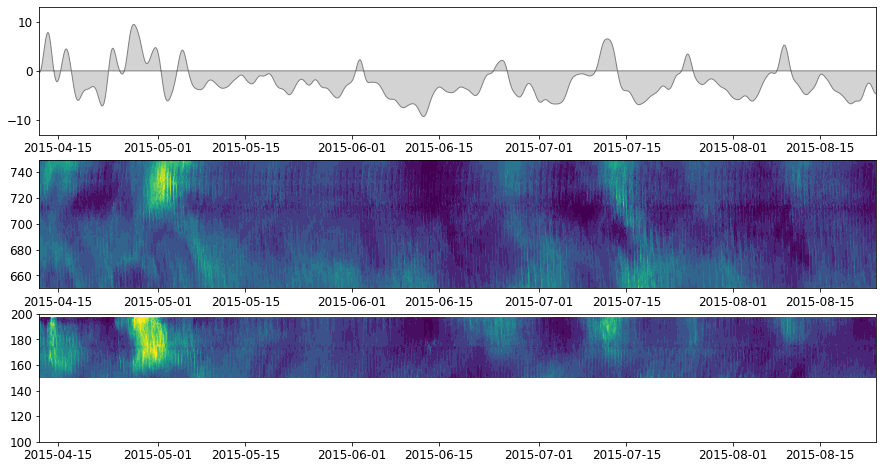

In [68]:
fig, axs = plt.subplots(3, 1, figsize=(15, 8))
axs[0].fill_between(HRDPS['time'], HRDPS['filtered'], facecolor='lightgray', edgecolor='gray')
axs[0].set_ylim([-13, 13])
axs[0].set_xlim(daterange)

axs[1].contourf(time, range(650, 750), rho.T, levels=np.arange(1021.5, 1023, 0.1), cmap='viridis_r', extend='both')
axs[1].set_xlim(daterange)

axs[2].contourf(time, range(150, 198), rho2.T, levels=np.arange(1021.5, 1023, 0.1), cmap='viridis_r', extend='both')
axs[2].set_ylim([100, 200])
axs[2].set_xlim(daterange)

In [85]:
g = 9.81
delrho=1
h=10
tau=0.2
L=1e5

W = g*delrho*h**2/(tau*L)

1/(2*W)

10.19367991845056

Full record

In [ ]:
# Initialize storage lists
for name in transects:
    for var in ['vel', 'no3', 'ssh']:
        transects[name][var] = []

# Loop through upwelling dates
for date in tqdm(upwelling_dates):
    
    # Open files
    files = {}
    with ExitStack() as stack:
        for key in ['ptrc_T', 'grid_T', 'grid_U', 'grid_V']:
            files[key] = stack.enter_context(xr.open_dataset(make_prefix(date) + f'_{key}.nc'))

        # Loop through transects
        for name in transects:

            # Parse orientation
            orient, kji = [transects[name][key] for key in ['orient', 'kji']]
            if orient == 'NS':
                vel, velname = 'u', 'vozocrtx'
                zyx_T = {'deptht': kji[0], 'y': slice(kji[1].start-1, kji[1].stop), 'x': kji[2]}
            elif orient == 'EW':
                vel, velname = 'v', 'vomecrty'
                zyx_T = {'deptht': kji[0], 'y': kji[1], 'x': slice(kji[2].start-1, kji[2].stop)}
            zyx_vel = dict(zip([f'depth{vel}', 'y', 'x'], kji))

            # Extract data
            transects[name]['vel'].append(files[f'grid_{vel.upper()}'][velname].isel(zyx_vel).values)
            transects[name]['no3'].append(files['ptrc_T'].nitrate.isel(zyx_T).values)
            zyx_T.pop('deptht')
            transects[name]['ssh'].append(files['grid_T'].sossheig.isel(zyx_T).values)

In [40]:
# Loop through transects
for name in transects:
    
    # Parse orientation
    orient, kji = [transects[name][key] for key in ['orient', 'kji']]
    if orient == 'NS':
        vel = 'u'
        zyx_T = {'y': slice(kji[1].start-1, kji[1].stop), 'x': kji[2]}
    elif orient == 'EW':
        vel = 'v'
        zyx_T = {'y': kji[1], 'x': slice(kji[2].start-1, kji[2].stop)}
    zyx_vel = dict(zip(['z', 'y', 'x'], kji))
    
    # Mask variables
    velmask, e3vel = [mask[key].isel(zyx_vel).values for key in [f'{vel}mask', f'e3{vel}_0']]
    zyx_vel.pop('z')
    e1vel, e2vel = [mask[key].isel(zyx_vel).values for key in [f'e1{vel}', f'e2{vel}']]
    e1t, e2t = [mask[key].isel(zyx_T).values for key in ['e1t', 'e2t']]
    
    # Concatenate model outputs
    for key in ['vel', 'no3', 'ssh']: transects[name][key] = np.concatenate(transects[name][key])
    
    # Interpolate tracers to grid
    e1e2t, e1e2vel = e1t * e2t, e1vel * e2vel
    transects[name]['ssh'] = 0.5 * velmask[:, 0, :] / e1e2vel * (e1e2t[:, :-1] * transects[name]['ssh'][:, :-1] + e1e2t[:, 1:] * transects[name]['ssh'][:, 1:])
    e1e2t, e1e2vel = e1e2t[:, np.newaxis, :], e1e2vel[:, np.newaxis, :]
    transects[name]['no3'] = 0.5 * velmask / e1e2vel * (e1e2t[..., :-1] * transects[name]['no3'][..., :-1] + e1e2t[..., 1:] * transects[name]['no3'][..., 1:])
    
    # Mask
    velmask_broadcast = np.broadcast_to(velmask, transects[name]['vel'].shape)
    for key in ['vel', 'no3']:
        transects[name][key] = np.ma.masked_where(velmask_broadcast==0, transects[name][key])
    
    # Build VVL widths
    transects[name]['e3vel'] = e3vel * np.expand_dims(1 + transects[name]['ssh'] / (e3vel * velmask).sum(axis=1), axis=1)

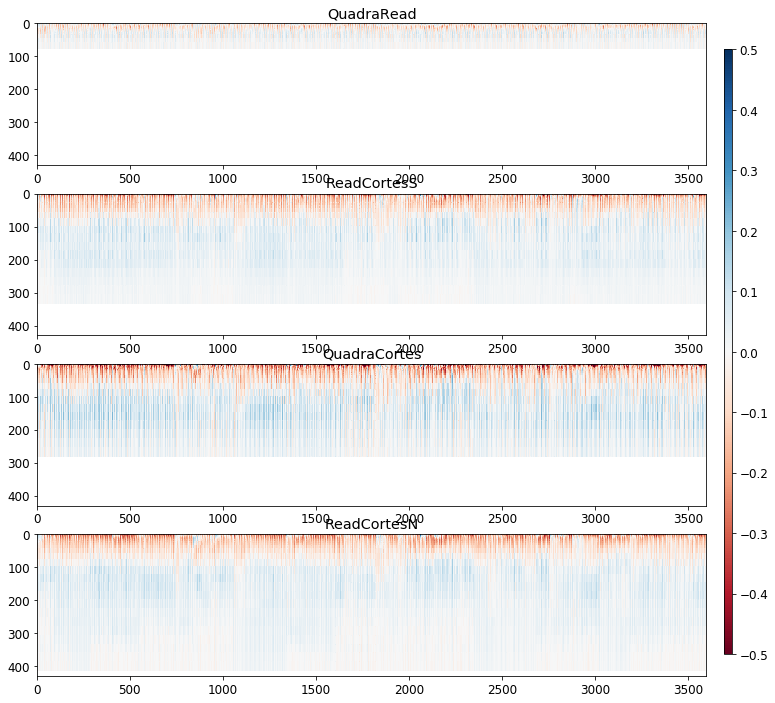

In [41]:
fig, axs = plt.subplots(4, 1, figsize=(12, 12))
deptht = mask.gdept_1d[0, :].values

for ax, name in zip(axs, transects):
    
    kji, shape = transects[name]['kji'], transects[name]['vel'].shape
    e1e2 = 'e1t' if orient == 'NS' else 'e2t' if orient == 'EW' else None
    tslc = slice(None, None)
    x = range(shape[0])
    
    ts = (transects[name]['vel'][tslc, kji[0], :] * mask[e1e2][:, kji[1], kji[2]].values[:, np.newaxis, :]).sum(axis=2).T
    c = ax.pcolormesh(x[tslc], deptht[kji[0]], ts/3600, vmin=-0.5, vmax=0.5, cmap='RdBu')
    ax.set_ylim([430, 0])
    ax.set_title(name)
    
cax = fig.add_axes([0.92, 0.15, 0.01, 0.7])
fig.colorbar(c, cax=cax, ticks=np.arange(-0.5, 0.51, 0.1))

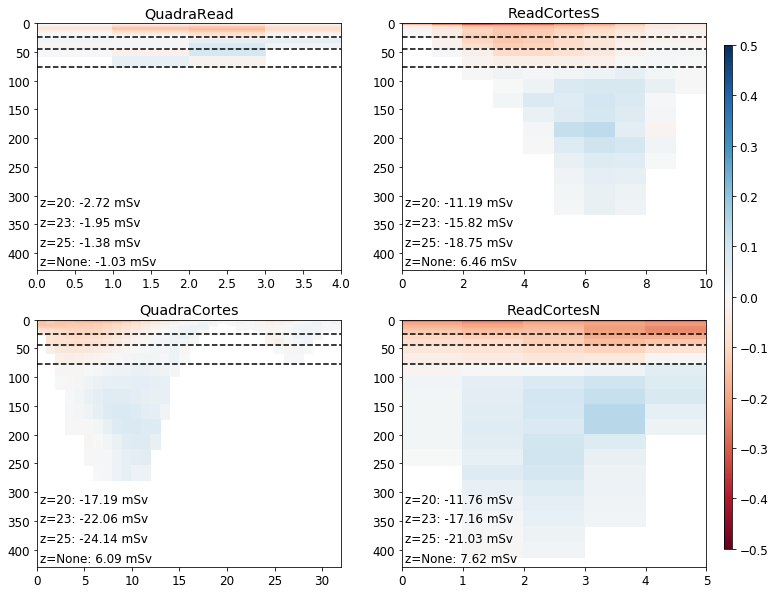

In [44]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
axs = axs.flatten()
deptht = mask.gdept_1d[0, :].values

for ax, name in zip(axs, transects):
    
    kji, shape = transects[name]['kji'], transects[name]['vel'].shape
    e1e2 = 'e1t' if orient == 'NS' else 'e2t' if orient == 'EW' else None
    tslc = slice(None, None)
    x = range(shape[2]+1)
    
    c = ax.pcolormesh(x, deptht[kji[0]], transects[name]['vel'][tslc, kji[0], :].mean(axis=0), vmin=-0.5, vmax=0.5, cmap='RdBu')
    ax.set_ylim([430, 0])
    ax.set_title(name)
    
    for z, ypos in zip([20, 23, 25, None], [0.26, 0.18, 0.1, 0.02]):
        if z is not None:
            ax.plot([0, shape[2]], [deptht[z], deptht[z]], 'k--')
        flux = ((transects[name]['vel'] * transects[name]['e3vel'])[tslc, :z, :].mean(axis=0).sum(axis=0) * mask[e1e2][0, kji[1], kji[2]]).sum()
        ax.text(0.01, ypos, f'z={z}: {flux*1e-3:.02f} mSv', transform=ax.transAxes)
    
cax = fig.add_axes([0.92, 0.15, 0.01, 0.7])
fig.colorbar(c, cax=cax, ticks=np.arange(-0.5, 0.51, 0.1))

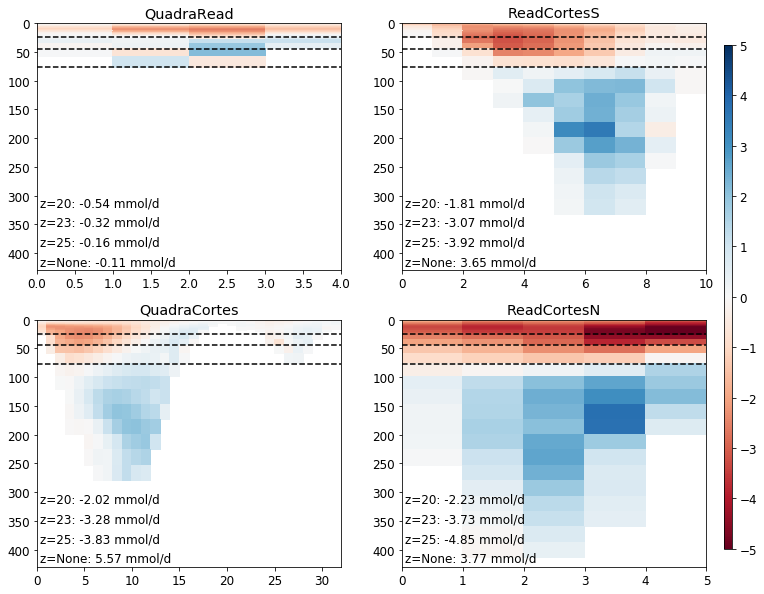

In [43]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
axs = axs.flatten()
deptht = mask.gdept_1d[0, :].values

for ax, name in zip(axs, transects):
    
    kji, shape = transects[name]['kji'], transects[name]['vel'].shape
    e1e2 = 'e1t' if orient == 'NS' else 'e2t' if orient == 'EW' else None
    tslc = slice(None, None)
    x = range(shape[2]+1)
    
    no3_flux = (transects[name]['vel'] * transects[name]['no3'])[tslc, kji[0], :].mean(axis=0)
    c = ax.pcolormesh(x, deptht[kji[0]], no3_flux, vmin=-5, vmax=5, cmap='RdBu')
    ax.set_ylim([430, 0])
    ax.set_title(name)
    
    for z, ypos in zip([20, 23, 25, None], [0.26, 0.18, 0.1, 0.02]):
        if z is not None:
            ax.plot([0, shape[2]], [deptht[z], deptht[z]], 'k--')
        flux = ((transects[name]['vel'] * transects[name]['no3'] * transects[name]['e3vel'])[tslc, :z, :].mean(axis=0).sum(axis=0) * mask[e1e2][0, kji[1], kji[2]]).sum()
        ax.text(0.01, ypos, f'z={z}: {flux/86400:.02f} mmol/d', transform=ax.transAxes)
    
cax = fig.add_axes([0.92, 0.15, 0.01, 0.7])
fig.colorbar(c, cax=cax, ticks=np.arange(-5, 5.1))

### Simulation

In [632]:
# ----- Execute simulations ------

points = [
    (773, 182),
    (756, 163),
    (740, 147),
]

releases = [
    datetime(2019, 6, 17, 23),
    datetime(2019, 6, 18, 23),
    datetime(2019, 6, 19, 23),
    datetime(2019, 6, 20, 23),
]

for startdate in releases:

    # Run parameters
    outfile = os.path.join(paths['results'], f"Discovery{startdate.strftime('%Y%b%dT%H%M%S')}.nc")
    lons, lats, depths = [], [], []
    for ji in points:
        j, i = ji
        lon, lat = [float(coords[key][0, j, i]) for key in ['glamt', 'gphit']]
        for depth in [10, 15, 20]:
            lons.append(lon)
            lats.append(lat)
            depths.append(depth)

    # Build fileset definitions
    variables = {'U': 'vozocrtx', 'V': 'vomecrty', 'W': 'vovecrtz'}
    dimensions, filenames = {}, {}
    for day in range(-1, duration.days + 3):
        prefix = make_prefix(startdate + timedelta(days=day))
        for key in ['U', 'V', 'W']:
            if day == -1:
                dimensions[key] = {'lon': 'glamf', 'lat': 'gphif', 'depth': 'depthw', 'time': 'time_counter'}
                filenames[key] = {'lon': paths['coords'], 'lat': paths['coords'], 'depth': f'{prefix}_grid_W.nc', 'data': []}
            filenames[key]['data'].append(f'{prefix}_grid_{key}.nc')

    # Load NEMO forcing
    field_set = FieldSet.from_nemo(filenames, variables, dimensions, field_chunksize='auto')

    # Execute run
    pset = ParticleSet.from_list(field_set, JITParticle, lon=lons, lat=lats, depth=depths, time=startdate)
    pset.execute(
        AdvectionRK4_3D, runtime=duration, dt=dt,
        output_file=pset.ParticleFile(name=outfile, outputdt=timedelta(hours=1)),
    )

INFO: Compiled JITParticleAdvectionRK4_3D ==> /tmp/parcels-1896/b11f171293a490360b9c6089fd5140e8_0.so
INFO: Temporary output files are stored in /data/bmoorema/results/parcels/upwelling/out-AYCDVUDT.
INFO: You can use "parcels_convert_npydir_to_netcdf /data/bmoorema/results/parcels/upwelling/out-AYCDVUDT" to convert these to a NetCDF file during the run.
100% (259200.0 of 259200.0) |############| Elapsed Time: 0:03:09 Time:  0:03:09
INFO: Compiled JITParticleAdvectionRK4_3D ==> /tmp/parcels-1896/aaa5445625fa359f4a34051125fe4f6e_0.so
INFO: Temporary output files are stored in /data/bmoorema/results/parcels/upwelling/out-OBPIUWMP.
INFO: You can use "parcels_convert_npydir_to_netcdf /data/bmoorema/results/parcels/upwelling/out-OBPIUWMP" to convert these to a NetCDF file during the run.
100% (259200.0 of 259200.0) |############| Elapsed Time: 0:03:28 Time:  0:03:28
INFO: Compiled JITParticleAdvectionRK4_3D ==> /tmp/parcels-1896/a066f7c0a92c69533e7e795ed91ba118_0.so
INFO: Temporary output f